In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/ATE_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/ATE_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/ATE_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

# Path to your GloVe pre-trained embeddings file
glove_file_path = 'glove.6B.300d.txt'

# Load GloVe embeddings
model = load_glove_model(glove_file_path)

Loading Glove Model
400000 words loaded!


In [4]:
word_embedding = model.get('hello')
print((word_embedding))

[-3.3712e-01 -2.1691e-01 -6.6365e-03 -4.1625e-01 -1.2555e+00 -2.8466e-02
 -7.2195e-01 -5.2887e-01  7.2085e-03  3.1997e-01  2.9425e-02 -1.3236e-02
  4.3511e-01  2.5716e-01  3.8995e-01 -1.1968e-01  1.5035e-01  4.4762e-01
  2.8407e-01  4.9339e-01  6.2826e-01  2.2888e-01 -4.0385e-01  2.7364e-02
  7.3679e-03  1.3995e-01  2.3346e-01  6.8122e-02  4.8422e-01 -1.9578e-02
 -5.4751e-01 -5.4983e-01 -3.4091e-02  8.0017e-03 -4.3065e-01 -1.8969e-02
 -8.5670e-02 -8.1123e-01 -2.1080e-01  3.7784e-01 -3.5046e-01  1.3684e-01
 -5.5661e-01  1.6835e-01 -2.2952e-01 -1.6184e-01  6.7345e-01 -4.6597e-01
 -3.1834e-02 -2.6037e-01 -1.7797e-01  1.9436e-02  1.0727e-01  6.6534e-01
 -3.4836e-01  4.7833e-02  1.6440e-01  1.4088e-01  1.9204e-01 -3.5009e-01
  2.6236e-01  1.7626e-01 -3.1367e-01  1.1709e-01  2.0378e-01  6.1775e-01
  4.9075e-01 -7.5210e-02 -1.1815e-01  1.8685e-01  4.0679e-01  2.8319e-01
 -1.6290e-01  3.8388e-02  4.3794e-01  8.8224e-02  5.9046e-01 -5.3515e-02
  3.8819e-02  1.8202e-01 -2.7599e-01  3.9474e-01 -2

In [5]:

def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            # Check if word exists in the model's vocabulary
            if word in model:
                embedding.append(model[word])
            else:
                # If word not found, use zero vector
                embedding.append([0] * model["hello"].size)
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 83  # maximum length of word in a text
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * model["hello"].size] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    # Filter out None values
    padded_embeddings = [embedding for embedding in padded_embeddings if embedding is not None]

    # Convert to tensor
    input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)

    return input_ids

In [6]:
x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_30830/886969634.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)


In [7]:
x_train.size()

torch.Size([906, 83, 300])

In [8]:
def convert_labels_to_fixed_length(labels, max_length):
    new_list=[]
    label_to_index = {'B': 0, 'I': 1, 'O': 2,'<pad>':3}
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 3
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 83
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [9]:
y_train.size()

torch.Size([906, 83])

In [10]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [11]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class RNNTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNTagger, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 4
learning_rate = 0.001
num_epochs = 150
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = RNNTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_30830/2469601546.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_30830/2469601546.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_30830/2469601546.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_30830/2469601546.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Epoch 1/150, Train Loss: 0.7612930983304977, Val Loss: 0.43767714500427246, Val F1: 0.2453154591012082, Train F1: 0.2720074318466156


  1%|█▉                                                                                                                                                | 2/150 [00:00<01:02,  2.38it/s]

Epoch 2/150, Train Loss: 0.4668528400361538, Val Loss: 0.39469096064567566, Val F1: 0.3424521458712704, Train F1: 0.30427526308250835


  2%|██▉                                                                                                                                               | 3/150 [00:01<01:02,  2.36it/s]

Epoch 3/150, Train Loss: 0.38264960050582886, Val Loss: 0.3658817708492279, Val F1: 0.41396572340580856, Train F1: 0.33558615318808777


  3%|███▉                                                                                                                                              | 4/150 [00:01<01:01,  2.36it/s]

Epoch 4/150, Train Loss: 0.36508530378341675, Val Loss: 0.325879842042923, Val F1: 0.4105401900168964, Train F1: 0.3654232831707305


  3%|████▊                                                                                                                                             | 5/150 [00:02<01:01,  2.36it/s]

Epoch 5/150, Train Loss: 0.3551935777068138, Val Loss: 0.30791836977005005, Val F1: 0.4837631371873663, Train F1: 0.39487557914932475


  4%|█████▊                                                                                                                                            | 6/150 [00:02<01:01,  2.35it/s]

Epoch 6/150, Train Loss: 0.31627536937594414, Val Loss: 0.2927709221839905, Val F1: 0.5375002970442644, Train F1: 0.49885606353144524


  5%|██████▊                                                                                                                                           | 7/150 [00:02<01:00,  2.35it/s]

Epoch 7/150, Train Loss: 0.3082425594329834, Val Loss: 0.2784939110279083, Val F1: 0.5365140032822301, Train F1: 0.47624519669817134


  5%|███████▊                                                                                                                                          | 8/150 [00:03<01:00,  2.34it/s]

Epoch 8/150, Train Loss: 0.2974139377474785, Val Loss: 0.2690771222114563, Val F1: 0.5998158165791984, Train F1: 0.5537637278550955


  6%|████████▊                                                                                                                                         | 9/150 [00:03<01:00,  2.33it/s]

Epoch 9/150, Train Loss: 0.2790209837257862, Val Loss: 0.2591036558151245, Val F1: 0.5846503877873916, Train F1: 0.5856991789953628


  7%|█████████▋                                                                                                                                       | 10/150 [00:04<00:59,  2.34it/s]

Epoch 10/150, Train Loss: 0.26250433549284935, Val Loss: 0.25138741731643677, Val F1: 0.628549176145884, Train F1: 0.6390902481660738


  7%|██████████▋                                                                                                                                      | 11/150 [00:04<00:59,  2.34it/s]

Epoch 11/150, Train Loss: 0.26996611803770065, Val Loss: 0.24490229785442352, Val F1: 0.6324169283372775, Train F1: 0.6540659282927123


  8%|███████████▌                                                                                                                                     | 12/150 [00:05<00:59,  2.34it/s]

Epoch 12/150, Train Loss: 0.24855384044349194, Val Loss: 0.23931100964546204, Val F1: 0.6480035916902843, Train F1: 0.6638652263175092


  9%|████████████▌                                                                                                                                    | 13/150 [00:05<00:58,  2.33it/s]

Epoch 13/150, Train Loss: 0.24950961209833622, Val Loss: 0.23385129868984222, Val F1: 0.6697122868163049, Train F1: 0.6627586681246973


  9%|█████████████▌                                                                                                                                   | 14/150 [00:05<00:58,  2.34it/s]

Epoch 14/150, Train Loss: 0.24520370364189148, Val Loss: 0.2289859652519226, Val F1: 0.6610810678340288, Train F1: 0.6574185543841929


 10%|██████████████▌                                                                                                                                  | 15/150 [00:06<00:57,  2.34it/s]

Epoch 15/150, Train Loss: 0.23058410175144672, Val Loss: 0.2250545769929886, Val F1: 0.6616207460544851, Train F1: 0.6844430517129224


 11%|███████████████▍                                                                                                                                 | 16/150 [00:06<00:56,  2.36it/s]

Epoch 16/150, Train Loss: 0.228486817330122, Val Loss: 0.2203235924243927, Val F1: 0.6783480144767556, Train F1: 0.6714535295429708


 11%|████████████████▍                                                                                                                                | 17/150 [00:07<00:56,  2.34it/s]

Epoch 17/150, Train Loss: 0.2140079326927662, Val Loss: 0.21685177087783813, Val F1: 0.6945287637185009, Train F1: 0.7124249500438088


 12%|█████████████████▍                                                                                                                               | 18/150 [00:07<00:56,  2.34it/s]

Epoch 18/150, Train Loss: 0.20486197620630264, Val Loss: 0.2140231728553772, Val F1: 0.6870726726794079, Train F1: 0.7351185484139016


 13%|██████████████████▎                                                                                                                              | 19/150 [00:08<00:55,  2.37it/s]

Epoch 19/150, Train Loss: 0.2003818992525339, Val Loss: 0.21341785788536072, Val F1: 0.6709835669858393, Train F1: 0.7397072038650864


 13%|███████████████████▎                                                                                                                             | 20/150 [00:08<00:55,  2.34it/s]

Epoch 20/150, Train Loss: 0.20727816224098206, Val Loss: 0.20736107230186462, Val F1: 0.714406018601387, Train F1: 0.7193697313496386


 14%|████████████████████▎                                                                                                                            | 21/150 [00:08<00:55,  2.33it/s]

Epoch 21/150, Train Loss: 0.19271805696189404, Val Loss: 0.20636799931526184, Val F1: 0.7225598581515085, Train F1: 0.7333845003617039


 15%|█████████████████████▎                                                                                                                           | 22/150 [00:09<00:55,  2.32it/s]

Epoch 22/150, Train Loss: 0.1988447792828083, Val Loss: 0.20823030173778534, Val F1: 0.721664741084791, Train F1: 0.7452941956318876


 15%|██████████████████████▏                                                                                                                          | 23/150 [00:09<00:53,  2.36it/s]

Epoch 23/150, Train Loss: 0.18230025563389063, Val Loss: 0.20188622176647186, Val F1: 0.7252706188816772, Train F1: 0.7685766986598185


 16%|███████████████████████▏                                                                                                                         | 24/150 [00:10<00:53,  2.34it/s]

Epoch 24/150, Train Loss: 0.18447080627083778, Val Loss: 0.2006596028804779, Val F1: 0.7109131265102978, Train F1: 0.7423530031625591


 17%|████████████████████████▏                                                                                                                        | 25/150 [00:10<00:54,  2.29it/s]

Epoch 25/150, Train Loss: 0.1749807931482792, Val Loss: 0.19912894070148468, Val F1: 0.713922074493738, Train F1: 0.7523376869449344


 17%|█████████████████████████▏                                                                                                                       | 26/150 [00:11<00:53,  2.32it/s]

Epoch 26/150, Train Loss: 0.19048021361231804, Val Loss: 0.1985730528831482, Val F1: 0.7379511481690425, Train F1: 0.752158904263417


 18%|██████████████████████████                                                                                                                       | 27/150 [00:11<00:52,  2.35it/s]

Epoch 27/150, Train Loss: 0.17575127072632313, Val Loss: 0.19691675901412964, Val F1: 0.7360325535357563, Train F1: 0.7557178728218071


 19%|███████████████████████████                                                                                                                      | 28/150 [00:11<00:51,  2.39it/s]

Epoch 28/150, Train Loss: 0.1706721894443035, Val Loss: 0.19547909498214722, Val F1: 0.7327036982425272, Train F1: 0.781577497546584


 19%|████████████████████████████                                                                                                                     | 29/150 [00:12<00:50,  2.39it/s]

Epoch 29/150, Train Loss: 0.1755363754928112, Val Loss: 0.1968686431646347, Val F1: 0.7450899323156522, Train F1: 0.7701213206299893


 20%|█████████████████████████████                                                                                                                    | 30/150 [00:12<00:50,  2.37it/s]

Epoch 30/150, Train Loss: 0.15510333888232708, Val Loss: 0.1967613250017166, Val F1: 0.738948760790866, Train F1: 0.7878237837362918


 21%|█████████████████████████████▉                                                                                                                   | 31/150 [00:13<00:50,  2.37it/s]

Epoch 31/150, Train Loss: 0.15674803033471107, Val Loss: 0.20204950869083405, Val F1: 0.7074812382870999, Train F1: 0.782542971260898


 21%|██████████████████████████████▉                                                                                                                  | 32/150 [00:13<00:49,  2.38it/s]

Epoch 32/150, Train Loss: 0.19833243638277054, Val Loss: 0.22012050449848175, Val F1: 0.7354906461668027, Train F1: 0.7588114207893193


 22%|███████████████████████████████▉                                                                                                                 | 33/150 [00:13<00:47,  2.48it/s]

Epoch 33/150, Train Loss: 0.179699731990695, Val Loss: 0.2149450033903122, Val F1: 0.6462447095219116, Train F1: 0.7484077107273844


 23%|████████████████████████████████▊                                                                                                                | 34/150 [00:14<00:44,  2.59it/s]

Epoch 34/150, Train Loss: 0.16719291172921658, Val Loss: 0.19913585484027863, Val F1: 0.7374415661900172, Train F1: 0.7810158740119623


 23%|█████████████████████████████████▊                                                                                                               | 35/150 [00:14<00:44,  2.57it/s]

Epoch 35/150, Train Loss: 0.15787735767662525, Val Loss: 0.1968061774969101, Val F1: 0.7051207396134792, Train F1: 0.7853301486164697


 24%|██████████████████████████████████▊                                                                                                              | 36/150 [00:15<00:46,  2.44it/s]

Epoch 36/150, Train Loss: 0.1477975808084011, Val Loss: 0.19751816987991333, Val F1: 0.7240586697982939, Train F1: 0.8079483807750875


 25%|███████████████████████████████████▊                                                                                                             | 37/150 [00:15<00:51,  2.21it/s]

Epoch 37/150, Train Loss: 0.13996096700429916, Val Loss: 0.199213907122612, Val F1: 0.7278213934149479, Train F1: 0.8158006579872302


 25%|████████████████████████████████████▋                                                                                                            | 38/150 [00:16<00:54,  2.07it/s]

Epoch 38/150, Train Loss: 0.14361266512423754, Val Loss: 0.19940327107906342, Val F1: 0.716923771121678, Train F1: 0.8243730754386034


 26%|█████████████████████████████████████▋                                                                                                           | 39/150 [00:16<00:57,  1.95it/s]

Epoch 39/150, Train Loss: 0.14084243215620518, Val Loss: 0.19927003979682922, Val F1: 0.7457782870621474, Train F1: 0.8187474793514914


 27%|██████████████████████████████████████▋                                                                                                          | 40/150 [00:17<01:02,  1.76it/s]

Epoch 40/150, Train Loss: 0.13586886320263147, Val Loss: 0.19913038611412048, Val F1: 0.7414223802318779, Train F1: 0.833497166207865


 27%|███████████████████████████████████████▋                                                                                                         | 41/150 [00:18<01:02,  1.76it/s]

Epoch 41/150, Train Loss: 0.1344659375026822, Val Loss: 0.20069262385368347, Val F1: 0.7457755643465854, Train F1: 0.83566751003728


 28%|████████████████████████████████████████▌                                                                                                        | 42/150 [00:18<01:01,  1.77it/s]

Epoch 42/150, Train Loss: 0.1366841970011592, Val Loss: 0.202773779630661, Val F1: 0.7403338112969235, Train F1: 0.8256954000613881


 29%|█████████████████████████████████████████▌                                                                                                       | 43/150 [00:19<01:00,  1.77it/s]

Epoch 43/150, Train Loss: 0.13351956196129322, Val Loss: 0.20203617215156555, Val F1: 0.7331470523778215, Train F1: 0.8340873992083926


 29%|██████████████████████████████████████████▌                                                                                                      | 44/150 [00:19<01:00,  1.76it/s]

Epoch 44/150, Train Loss: 0.12582140509039164, Val Loss: 0.20260371267795563, Val F1: 0.736144891299781, Train F1: 0.8353484146536055


 30%|███████████████████████████████████████████▌                                                                                                     | 45/150 [00:20<01:05,  1.60it/s]

Epoch 45/150, Train Loss: 0.12296636030077934, Val Loss: 0.20660080015659332, Val F1: 0.7414462731651467, Train F1: 0.8519393419875607


 31%|████████████████████████████████████████████▍                                                                                                    | 46/150 [00:21<01:07,  1.53it/s]

Epoch 46/150, Train Loss: 0.12919570691883564, Val Loss: 0.21195363998413086, Val F1: 0.7465675073497483, Train F1: 0.8498103317094581


 31%|█████████████████████████████████████████████▍                                                                                                   | 47/150 [00:22<01:09,  1.49it/s]

Epoch 47/150, Train Loss: 0.11958747543394566, Val Loss: 0.21576867997646332, Val F1: 0.7256973387234081, Train F1: 0.8619000238659076


 32%|██████████████████████████████████████████████▍                                                                                                  | 48/150 [00:22<01:04,  1.57it/s]

Epoch 48/150, Train Loss: 0.12512196972966194, Val Loss: 0.21128053963184357, Val F1: 0.740495919395864, Train F1: 0.8624075866862059


 33%|███████████████████████████████████████████████▎                                                                                                 | 49/150 [00:23<01:01,  1.63it/s]

Epoch 49/150, Train Loss: 0.11960447859019041, Val Loss: 0.21319110691547394, Val F1: 0.73233430145674, Train F1: 0.8609713293426469


 33%|████████████████████████████████████████████████▎                                                                                                | 50/150 [00:23<00:59,  1.68it/s]

Epoch 50/150, Train Loss: 0.11590365506708622, Val Loss: 0.2131825089454651, Val F1: 0.7225582399007545, Train F1: 0.8591784531762047


 34%|█████████████████████████████████████████████████▎                                                                                               | 51/150 [00:24<01:00,  1.64it/s]

Epoch 51/150, Train Loss: 0.11173751670867205, Val Loss: 0.21477384865283966, Val F1: 0.7303719503105651, Train F1: 0.8729099661953045


 35%|██████████████████████████████████████████████████▎                                                                                              | 52/150 [00:24<00:55,  1.75it/s]

Epoch 52/150, Train Loss: 0.11618833523243666, Val Loss: 0.21686141192913055, Val F1: 0.738772965045592, Train F1: 0.8723868621621301


 35%|███████████████████████████████████████████████████▏                                                                                             | 53/150 [00:25<00:52,  1.86it/s]

Epoch 53/150, Train Loss: 0.11868530604988337, Val Loss: 0.21362391114234924, Val F1: 0.7292560339192832, Train F1: 0.8693165559049998


 36%|████████████████████████████████████████████████████▏                                                                                            | 54/150 [00:25<00:49,  1.94it/s]

Epoch 54/150, Train Loss: 0.10666539426892996, Val Loss: 0.21342545747756958, Val F1: 0.724628552067193, Train F1: 0.8818668946129553


 37%|█████████████████████████████████████████████████████▏                                                                                           | 55/150 [00:26<00:49,  1.90it/s]

Epoch 55/150, Train Loss: 0.10773477610200644, Val Loss: 0.21701417863368988, Val F1: 0.7285202750163343, Train F1: 0.8790971320103254


 37%|██████████████████████████████████████████████████████▏                                                                                          | 56/150 [00:26<00:50,  1.87it/s]

Epoch 56/150, Train Loss: 0.11115335486829281, Val Loss: 0.22567355632781982, Val F1: 0.7225208909353479, Train F1: 0.8852836340357592


 38%|███████████████████████████████████████████████████████                                                                                          | 57/150 [00:27<00:49,  1.89it/s]

Epoch 57/150, Train Loss: 0.10350228659808636, Val Loss: 0.22214281558990479, Val F1: 0.7255016991415002, Train F1: 0.8896045893079341


 39%|████████████████████████████████████████████████████████                                                                                         | 58/150 [00:27<00:49,  1.86it/s]

Epoch 58/150, Train Loss: 0.09543133247643709, Val Loss: 0.22730305790901184, Val F1: 0.7195391953032746, Train F1: 0.8919493385240099


 39%|█████████████████████████████████████████████████████████                                                                                        | 59/150 [00:28<00:48,  1.86it/s]

Epoch 59/150, Train Loss: 0.10135494731366634, Val Loss: 0.23520013689994812, Val F1: 0.7221481941093183, Train F1: 0.8831605795292842


 40%|██████████████████████████████████████████████████████████                                                                                       | 60/150 [00:29<00:49,  1.81it/s]

Epoch 60/150, Train Loss: 0.09613427007570863, Val Loss: 0.23502753674983978, Val F1: 0.7210334933431716, Train F1: 0.8995291994399621


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 61/150 [00:29<00:53,  1.66it/s]

Epoch 61/150, Train Loss: 0.09955421928316355, Val Loss: 0.23093372583389282, Val F1: 0.7293326856995409, Train F1: 0.8953712294689646


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 62/150 [00:30<00:51,  1.71it/s]

Epoch 62/150, Train Loss: 0.09666033834218979, Val Loss: 0.23473015427589417, Val F1: 0.7151921813239276, Train F1: 0.889582613050577


 42%|████████████████████████████████████████████████████████████▉                                                                                    | 63/150 [00:30<00:49,  1.75it/s]

Epoch 63/150, Train Loss: 0.08679167926311493, Val Loss: 0.23804537951946259, Val F1: 0.7055712638635968, Train F1: 0.9130866187432665


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 64/150 [00:31<00:47,  1.83it/s]

Epoch 64/150, Train Loss: 0.09322721417993307, Val Loss: 0.23937709629535675, Val F1: 0.7140360854606603, Train F1: 0.898589494782245


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 65/150 [00:31<00:48,  1.74it/s]

Epoch 65/150, Train Loss: 0.08416297100484371, Val Loss: 0.23625122010707855, Val F1: 0.7032547716328151, Train F1: 0.9125870582055303


 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 66/150 [00:32<00:47,  1.76it/s]

Epoch 66/150, Train Loss: 0.07800479372963309, Val Loss: 0.2396276742219925, Val F1: 0.7224625014091139, Train F1: 0.9276907978619393


 45%|████████████████████████████████████████████████████████████████▊                                                                                | 67/150 [00:33<00:45,  1.82it/s]

Epoch 67/150, Train Loss: 0.07542225532233715, Val Loss: 0.25052207708358765, Val F1: 0.7154291141559259, Train F1: 0.9288721713551547


 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 68/150 [00:33<00:45,  1.79it/s]

Epoch 68/150, Train Loss: 0.08261745050549507, Val Loss: 0.2606433928012848, Val F1: 0.7054716704128157, Train F1: 0.9219884933743719


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 69/150 [00:34<00:52,  1.55it/s]

Epoch 69/150, Train Loss: 0.0791081809438765, Val Loss: 0.2510842978954315, Val F1: 0.7081581412434098, Train F1: 0.92171194123406


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 70/150 [00:35<00:56,  1.42it/s]

Epoch 70/150, Train Loss: 0.07963418867439032, Val Loss: 0.2531201243400574, Val F1: 0.7103425646794085, Train F1: 0.9169039906916697


 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 71/150 [00:36<00:56,  1.40it/s]

Epoch 71/150, Train Loss: 0.07200227165594697, Val Loss: 0.2543027400970459, Val F1: 0.7093522322645779, Train F1: 0.9275666772117863


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 72/150 [00:36<00:53,  1.46it/s]

Epoch 72/150, Train Loss: 0.07366064423695207, Val Loss: 0.258019357919693, Val F1: 0.7110571896711296, Train F1: 0.9372688094090735


 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 73/150 [00:37<00:52,  1.47it/s]

Epoch 73/150, Train Loss: 0.0698004555888474, Val Loss: 0.26034101843833923, Val F1: 0.7145525202011417, Train F1: 0.9400042887808495


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 74/150 [00:37<00:49,  1.53it/s]

Epoch 74/150, Train Loss: 0.06500417739152908, Val Loss: 0.26418283581733704, Val F1: 0.710188549937811, Train F1: 0.9444515708196068


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 75/150 [00:38<00:47,  1.58it/s]

Epoch 75/150, Train Loss: 0.06615584436804056, Val Loss: 0.2714013457298279, Val F1: 0.7119695571788647, Train F1: 0.9398692450563023


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 76/150 [00:39<00:45,  1.62it/s]

Epoch 76/150, Train Loss: 0.0691874036565423, Val Loss: 0.27125346660614014, Val F1: 0.6979132000366514, Train F1: 0.9324145682726055


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 77/150 [00:39<00:45,  1.59it/s]

Epoch 77/150, Train Loss: 0.06327524874359369, Val Loss: 0.27548182010650635, Val F1: 0.7061210483633117, Train F1: 0.9464716037689229


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 78/150 [00:40<00:43,  1.67it/s]

Epoch 78/150, Train Loss: 0.06574485078454018, Val Loss: 0.2825261354446411, Val F1: 0.7154836770379595, Train F1: 0.9362061379085767


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 79/150 [00:40<00:41,  1.70it/s]

Epoch 79/150, Train Loss: 0.06387085886672139, Val Loss: 0.2767944037914276, Val F1: 0.7023243188672189, Train F1: 0.942929100152194


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 80/150 [00:41<00:43,  1.62it/s]

Epoch 80/150, Train Loss: 0.057503634598106146, Val Loss: 0.283557653427124, Val F1: 0.7061736355319512, Train F1: 0.9534621859338316


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 81/150 [00:42<00:47,  1.45it/s]

Epoch 81/150, Train Loss: 0.059883201494812965, Val Loss: 0.2838681638240814, Val F1: 0.7048740755491391, Train F1: 0.9514446963764355


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 82/150 [00:42<00:44,  1.55it/s]

Epoch 82/150, Train Loss: 0.056082398165017366, Val Loss: 0.2869187891483307, Val F1: 0.7023413583233843, Train F1: 0.9535398735508138


 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 83/150 [00:43<00:43,  1.52it/s]

Epoch 83/150, Train Loss: 0.06098279170691967, Val Loss: 0.287888765335083, Val F1: 0.7069500378138391, Train F1: 0.9502744683951646


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 84/150 [00:44<00:44,  1.48it/s]

Epoch 84/150, Train Loss: 0.05746720638126135, Val Loss: 0.28898879885673523, Val F1: 0.7055224648439111, Train F1: 0.9568626364227171


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 85/150 [00:45<00:46,  1.40it/s]

Epoch 85/150, Train Loss: 0.0512732001952827, Val Loss: 0.2904618978500366, Val F1: 0.7052490832992054, Train F1: 0.9620314291342505


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 86/150 [00:45<00:42,  1.50it/s]

Epoch 86/150, Train Loss: 0.05080363480374217, Val Loss: 0.2940927743911743, Val F1: 0.7024232258206142, Train F1: 0.9543042180157417


 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 87/150 [00:46<00:39,  1.60it/s]

Epoch 87/150, Train Loss: 0.053644685074687004, Val Loss: 0.2933962941169739, Val F1: 0.7199995527309385, Train F1: 0.9584789595100478


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 88/150 [00:46<00:36,  1.69it/s]

Epoch 88/150, Train Loss: 0.04793792311102152, Val Loss: 0.29619622230529785, Val F1: 0.7096907810669072, Train F1: 0.9600897902022196


 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 89/150 [00:47<00:34,  1.75it/s]

Epoch 89/150, Train Loss: 0.046105004381388426, Val Loss: 0.3038593530654907, Val F1: 0.7033369899528346, Train F1: 0.9630016130096049


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 90/150 [00:47<00:33,  1.78it/s]

Epoch 90/150, Train Loss: 0.044829797465354204, Val Loss: 0.3112952411174774, Val F1: 0.6987329359219773, Train F1: 0.9679963353089467


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 91/150 [00:48<00:31,  1.85it/s]

Epoch 91/150, Train Loss: 0.0436689923517406, Val Loss: 0.3109007477760315, Val F1: 0.70888423434949, Train F1: 0.9686395212230304


 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 92/150 [00:48<00:30,  1.90it/s]

Epoch 92/150, Train Loss: 0.044911894015967846, Val Loss: 0.3153797388076782, Val F1: 0.7049738749277238, Train F1: 0.9687154012172684


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 93/150 [00:49<00:29,  1.90it/s]

Epoch 93/150, Train Loss: 0.043849083594977856, Val Loss: 0.31594347953796387, Val F1: 0.7010745552786215, Train F1: 0.9651534396719605


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 94/150 [00:49<00:30,  1.87it/s]

Epoch 94/150, Train Loss: 0.04188812244683504, Val Loss: 0.32265132665634155, Val F1: 0.6934300675800359, Train F1: 0.9677061161147703


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 95/150 [00:50<00:29,  1.89it/s]

Epoch 95/150, Train Loss: 0.0421175048686564, Val Loss: 0.32492730021476746, Val F1: 0.6921306590345006, Train F1: 0.97057535749232


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 96/150 [00:50<00:27,  1.95it/s]

Epoch 96/150, Train Loss: 0.03863881388679147, Val Loss: 0.3216750919818878, Val F1: 0.6921903887307602, Train F1: 0.9722272714193917


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 97/150 [00:51<00:26,  2.02it/s]

Epoch 97/150, Train Loss: 0.03927979525178671, Val Loss: 0.33390942215919495, Val F1: 0.6953455720313725, Train F1: 0.971513769032412


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 98/150 [00:51<00:25,  2.03it/s]

Epoch 98/150, Train Loss: 0.04186120629310608, Val Loss: 0.3409615755081177, Val F1: 0.6944264309472006, Train F1: 0.9689868594994518


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 99/150 [00:52<00:24,  2.07it/s]

Epoch 99/150, Train Loss: 0.04769323905929923, Val Loss: 0.3317320942878723, Val F1: 0.6907439037046311, Train F1: 0.9630994758467899


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 100/150 [00:52<00:23,  2.10it/s]

Epoch 100/150, Train Loss: 0.057410585694015026, Val Loss: 0.32185226678848267, Val F1: 0.7032841477353249, Train F1: 0.9522509301230389


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 101/150 [00:53<00:23,  2.06it/s]

Epoch 101/150, Train Loss: 0.052022464107722044, Val Loss: 0.3244968354701996, Val F1: 0.7019551555744936, Train F1: 0.9526148775119961


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 102/150 [00:53<00:22,  2.10it/s]

Epoch 102/150, Train Loss: 0.04560893261805177, Val Loss: 0.33086317777633667, Val F1: 0.7015382470285929, Train F1: 0.9650253040362211


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/150 [00:54<00:22,  2.12it/s]

Epoch 103/150, Train Loss: 0.04484086390584707, Val Loss: 0.32429811358451843, Val F1: 0.7072812434033313, Train F1: 0.9676718758838534


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 104/150 [00:54<00:23,  1.96it/s]

Epoch 104/150, Train Loss: 0.0415565175935626, Val Loss: 0.3288712799549103, Val F1: 0.7037997776775645, Train F1: 0.961771134641912


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 105/150 [00:55<00:23,  1.91it/s]

Epoch 105/150, Train Loss: 0.04230105923488736, Val Loss: 0.3383182883262634, Val F1: 0.6954624231585614, Train F1: 0.9680491340188483


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 106/150 [00:55<00:23,  1.88it/s]

Epoch 106/150, Train Loss: 0.04675698280334473, Val Loss: 0.3421950042247772, Val F1: 0.6869209645907813, Train F1: 0.9667983026825775


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 107/150 [00:56<00:22,  1.92it/s]

Epoch 107/150, Train Loss: 0.043039515148848295, Val Loss: 0.34369659423828125, Val F1: 0.6978190448725252, Train F1: 0.9650880540159277


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 108/150 [00:56<00:21,  1.93it/s]

Epoch 108/150, Train Loss: 0.04354901984333992, Val Loss: 0.3411226272583008, Val F1: 0.7031235695324062, Train F1: 0.9593971901103135


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 109/150 [00:57<00:21,  1.94it/s]

Epoch 109/150, Train Loss: 0.040105062536895275, Val Loss: 0.34847426414489746, Val F1: 0.6944363008077924, Train F1: 0.9631161810207902


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 110/150 [00:57<00:20,  1.93it/s]

Epoch 110/150, Train Loss: 0.040142571553587914, Val Loss: 0.34717312455177307, Val F1: 0.6976074498657705, Train F1: 0.9678583509086021


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 111/150 [00:58<00:20,  1.88it/s]

Epoch 111/150, Train Loss: 0.03716071089729667, Val Loss: 0.3575817942619324, Val F1: 0.6892155107444156, Train F1: 0.9710691035521406


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 112/150 [00:59<00:20,  1.83it/s]

Epoch 112/150, Train Loss: 0.03696995438076556, Val Loss: 0.35390275716781616, Val F1: 0.6937813745444029, Train F1: 0.9711037860847405


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 113/150 [00:59<00:20,  1.79it/s]

Epoch 113/150, Train Loss: 0.03205491369590163, Val Loss: 0.35435783863067627, Val F1: 0.6886621043550548, Train F1: 0.9765841964340938


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 114/150 [01:00<00:21,  1.68it/s]

Epoch 114/150, Train Loss: 0.03380720177665353, Val Loss: 0.3607235252857208, Val F1: 0.6873417710567383, Train F1: 0.9731173511296799


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 115/150 [01:00<00:21,  1.63it/s]

Epoch 115/150, Train Loss: 0.031903411727398634, Val Loss: 0.3588690161705017, Val F1: 0.6942537219542881, Train F1: 0.9765649238401982


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 116/150 [01:01<00:19,  1.74it/s]

Epoch 116/150, Train Loss: 0.031657357001677155, Val Loss: 0.36223676800727844, Val F1: 0.6884842181232383, Train F1: 0.9744699481707867


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 117/150 [01:01<00:18,  1.82it/s]

Epoch 117/150, Train Loss: 0.03069582232274115, Val Loss: 0.36986100673675537, Val F1: 0.6842663636197331, Train F1: 0.975785602888835


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 118/150 [01:02<00:17,  1.85it/s]

Epoch 118/150, Train Loss: 0.0299307283712551, Val Loss: 0.3672026991844177, Val F1: 0.6920110934966704, Train F1: 0.9772659488656154


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 119/150 [01:03<00:18,  1.72it/s]

Epoch 119/150, Train Loss: 0.03391433460637927, Val Loss: 0.3669249415397644, Val F1: 0.6854433507357353, Train F1: 0.9739637920375055


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 120/150 [01:03<00:17,  1.74it/s]

Epoch 120/150, Train Loss: 0.033342879731208086, Val Loss: 0.37601280212402344, Val F1: 0.6815346836283246, Train F1: 0.9714736258700265


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 121/150 [01:04<00:16,  1.81it/s]

Epoch 121/150, Train Loss: 0.03258113446645439, Val Loss: 0.3771759271621704, Val F1: 0.6914722513717934, Train F1: 0.9746648271028862


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 122/150 [01:04<00:14,  1.87it/s]

Epoch 122/150, Train Loss: 0.03147293976508081, Val Loss: 0.3786188066005707, Val F1: 0.6849877843514087, Train F1: 0.9743796984103249


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 123/150 [01:05<00:14,  1.84it/s]

Epoch 123/150, Train Loss: 0.03206460387445986, Val Loss: 0.3775341212749481, Val F1: 0.6819559195912079, Train F1: 0.972892302791747


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 124/150 [01:05<00:14,  1.79it/s]

Epoch 124/150, Train Loss: 0.028541428735479712, Val Loss: 0.3811451494693756, Val F1: 0.6806051602573738, Train F1: 0.9782549623631391


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 125/150 [01:06<00:13,  1.84it/s]

Epoch 125/150, Train Loss: 0.030736022163182497, Val Loss: 0.3845157027244568, Val F1: 0.6892489004761594, Train F1: 0.9767129011052248


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/150 [01:06<00:13,  1.74it/s]

Epoch 126/150, Train Loss: 0.02969283564016223, Val Loss: 0.38394203782081604, Val F1: 0.6852637009841582, Train F1: 0.9766149156337278


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 127/150 [01:07<00:13,  1.75it/s]

Epoch 127/150, Train Loss: 0.027370781695935875, Val Loss: 0.3854934573173523, Val F1: 0.6816645159889094, Train F1: 0.978446142018381


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 128/150 [01:08<00:12,  1.69it/s]

Epoch 128/150, Train Loss: 0.030057188821956515, Val Loss: 0.3907108008861542, Val F1: 0.6852208038568536, Train F1: 0.9748255182108283


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 129/150 [01:08<00:12,  1.65it/s]

Epoch 129/150, Train Loss: 0.02732807374559343, Val Loss: 0.3926953673362732, Val F1: 0.6782704872084819, Train F1: 0.978065003706714


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 130/150 [01:09<00:12,  1.61it/s]

Epoch 130/150, Train Loss: 0.029251853469759226, Val Loss: 0.3907819986343384, Val F1: 0.6848628488373909, Train F1: 0.9770657959384236


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 131/150 [01:10<00:12,  1.53it/s]

Epoch 131/150, Train Loss: 0.028441708302125335, Val Loss: 0.39030513167381287, Val F1: 0.688916326366575, Train F1: 0.9760904085797363


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 132/150 [01:10<00:11,  1.55it/s]

Epoch 132/150, Train Loss: 0.033649263670668006, Val Loss: 0.3964920938014984, Val F1: 0.6818791210273084, Train F1: 0.9734384963064919


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 133/150 [01:11<00:11,  1.49it/s]

Epoch 133/150, Train Loss: 0.030116135254502296, Val Loss: 0.3960307538509369, Val F1: 0.6748782393278713, Train F1: 0.9763485227254786


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 134/150 [01:12<00:10,  1.50it/s]

Epoch 134/150, Train Loss: 0.027533565880730748, Val Loss: 0.39931580424308777, Val F1: 0.6791335301641487, Train F1: 0.9781413228743648


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 135/150 [01:12<00:09,  1.50it/s]

Epoch 135/150, Train Loss: 0.026572610368020833, Val Loss: 0.40029048919677734, Val F1: 0.6768576865029531, Train F1: 0.9774851152213491


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 136/150 [01:13<00:09,  1.53it/s]

Epoch 136/150, Train Loss: 0.03452375531196594, Val Loss: 0.40546682476997375, Val F1: 0.6749790626382546, Train F1: 0.9729973330155468


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 137/150 [01:14<00:08,  1.56it/s]

Epoch 137/150, Train Loss: 0.03268634853884578, Val Loss: 0.4066879451274872, Val F1: 0.6773445495528696, Train F1: 0.9731510209101415


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/150 [01:14<00:07,  1.59it/s]

Epoch 138/150, Train Loss: 0.027529827784746885, Val Loss: 0.410898357629776, Val F1: 0.6695894304558095, Train F1: 0.9749630571085728


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 139/150 [01:15<00:06,  1.65it/s]

Epoch 139/150, Train Loss: 0.02730635809712112, Val Loss: 0.409336656332016, Val F1: 0.6679968895045079, Train F1: 0.9776748008109648


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 140/150 [01:15<00:06,  1.59it/s]

Epoch 140/150, Train Loss: 0.02580715052317828, Val Loss: 0.4122803807258606, Val F1: 0.672375767046476, Train F1: 0.9795511337981091


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 141/150 [01:16<00:05,  1.51it/s]

Epoch 141/150, Train Loss: 0.025647710193879902, Val Loss: 0.41143515706062317, Val F1: 0.6753973625483028, Train F1: 0.9778257177835032


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 142/150 [01:17<00:05,  1.41it/s]

Epoch 142/150, Train Loss: 0.025038689957000315, Val Loss: 0.41680335998535156, Val F1: 0.6736295490416934, Train F1: 0.9797971496218805


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [01:18<00:04,  1.51it/s]

Epoch 143/150, Train Loss: 0.029413881711661816, Val Loss: 0.4216238558292389, Val F1: 0.6746369499500598, Train F1: 0.9733751893517308


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 144/150 [01:18<00:03,  1.50it/s]

Epoch 144/150, Train Loss: 0.03331130091100931, Val Loss: 0.42399781942367554, Val F1: 0.674391859693196, Train F1: 0.9686982657096443


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 145/150 [01:19<00:03,  1.52it/s]

Epoch 145/150, Train Loss: 0.03361946530640125, Val Loss: 0.40678584575653076, Val F1: 0.6725360168303361, Train F1: 0.9732355578772551


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [01:19<00:02,  1.61it/s]

Epoch 146/150, Train Loss: 0.030288156936876476, Val Loss: 0.4249036908149719, Val F1: 0.6606696398555078, Train F1: 0.9750803988251265


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 147/150 [01:20<00:01,  1.58it/s]

Epoch 147/150, Train Loss: 0.03266499610617757, Val Loss: 0.42805030941963196, Val F1: 0.6650387438100385, Train F1: 0.9719226493196736


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [01:21<00:01,  1.64it/s]

Epoch 148/150, Train Loss: 0.028048723936080933, Val Loss: 0.41396376490592957, Val F1: 0.6699108923186969, Train F1: 0.9790050677555737


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [01:21<00:00,  1.66it/s]

Epoch 149/150, Train Loss: 0.028513066936284304, Val Loss: 0.4100508689880371, Val F1: 0.682858848827275, Train F1: 0.9753223676287854


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:22<00:00,  1.82it/s]

Epoch 150/150, Train Loss: 0.026188299525529146, Val Loss: 0.4184236228466034, Val F1: 0.6632791372310881, Train F1: 0.9779164698253044


In [12]:
# Save the model
torch.save(model.state_dict(), 't2_model1_glove.pth')

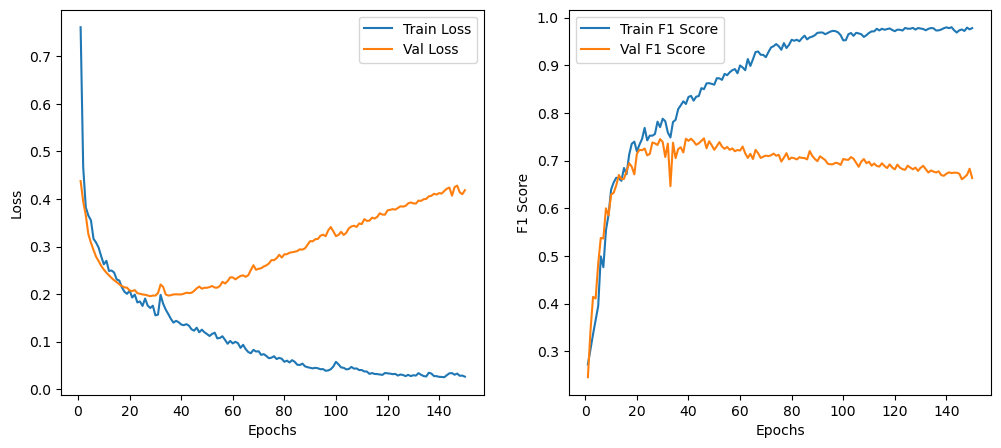

In [13]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()